TRAINING STARTED.

Epoch [1/100], Train Loss: 0.8071, Val Loss: 0.4225, Train Accuracy: 0.8333, Val Accuracy: 0.8704
Epoch [11/100], Train Loss: 0.3008, Val Loss: 0.4034, Train Accuracy: 0.9074, Val Accuracy: 0.8519
Epoch [21/100], Train Loss: 0.1270, Val Loss: 0.6732, Train Accuracy: 0.9630, Val Accuracy: 0.8519
Epoch [31/100], Train Loss: 0.0553, Val Loss: 0.8743, Train Accuracy: 0.9907, Val Accuracy: 0.8333
Epoch [41/100], Train Loss: 0.0267, Val Loss: 0.9789, Train Accuracy: 0.9954, Val Accuracy: 0.8704
Epoch [51/100], Train Loss: 0.0118, Val Loss: 1.0583, Train Accuracy: 1.0000, Val Accuracy: 0.8519
Epoch [61/100], Train Loss: 0.0063, Val Loss: 1.1061, Train Accuracy: 1.0000, Val Accuracy: 0.8519
Epoch [71/100], Train Loss: 0.0041, Val Loss: 1.1460, Train Accuracy: 1.0000, Val Accuracy: 0.8519
Epoch [81/100], Train Loss: 0.0030, Val Loss: 1.1795, Train Accuracy: 1.0000, Val Accuracy: 0.8519
Epoch [91/100], Train Loss: 0.0023, Val Loss: 1.2079, Train Accuracy: 1.0000, Val Accuracy:

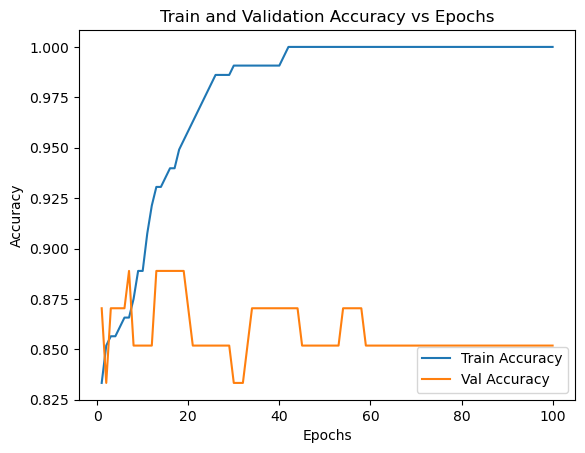

Test Accuracy: 0.8519
Test F1 Score: 0.8503
Test Precision: 0.8513
Test Recall: 0.8519


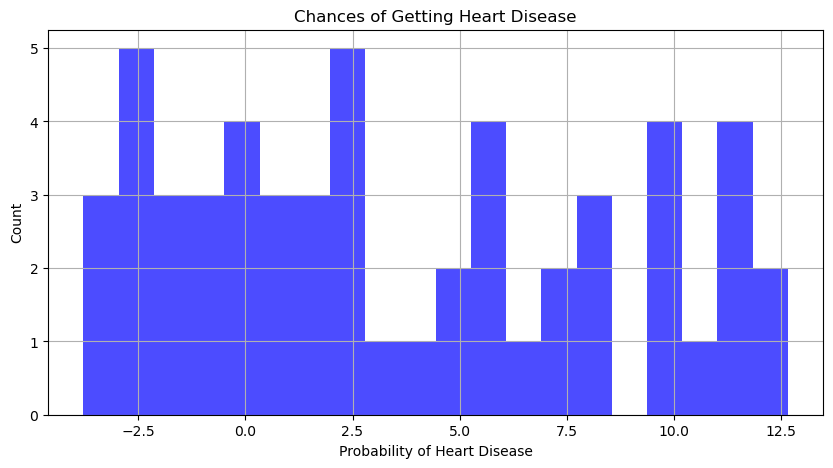

In [4]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt


#Data Loading Process

# Read CSV file
data = pd.read_csv('Heart_Disease_Prediction.csv')

# Separate features and labels
X = data.drop(columns=['num']).values
y = data['num'].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors (optional)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


#Create Model Class

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


#Training and Evaluation


# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 100
layer_dim = 1
output_dim = 10
num_epochs = 100
learning_rate = 0.1

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training
print('TRAINING STARTED.\n')
train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for i in range(len(X_train_tensor)):
        images = X_train_tensor[i].view(1, 1, input_dim).to(device)
        labels = torch.tensor([y_train[i]]).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    train_loss_list.append(train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor.view(-1, 1, input_dim).to(device))
        val_loss = loss_fn(outputs, y_test_tensor.to(device)).item()
        _, predicted = torch.max(outputs, 1)

    # Calculate evaluation metrics
    val_accuracy = accuracy_score(y_test, predicted.cpu())
    val_accuracy_list.append(val_accuracy)
    train_accuracy = accuracy_score(y_train, [torch.max(model(X_train_tensor[i].view(1, 1, input_dim).to(device)), 1)[1].cpu().detach().numpy()[0] for i in range(len(X_train_tensor))])
    train_accuracy_list.append(train_accuracy)
    if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting
plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracy_list, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy vs Epochs')
plt.legend()
plt.show()

# Calculate evaluation metrics
test_outputs = model(X_test_tensor.view(-1, 1, input_dim).to(device))
_, test_predicted = torch.max(test_outputs, 1)
test_accuracy = accuracy_score(y_test, test_predicted.cpu())
test_f1 = f1_score(y_test, test_predicted.cpu(), average='weighted')
test_precision = precision_score(y_test, test_predicted.cpu(), average='weighted')
test_recall = recall_score(y_test, test_predicted.cpu(), average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')

# Predict probabilities for the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.view(-1, 1, input_dim).to(device))
    probabilities = test_outputs.cpu().numpy()

# Plotting the chances of getting heart disease or not
plt.figure(figsize=(10, 5))
plt.hist(probabilities[:, 1], bins=20, color='blue', alpha=0.7)
plt.xlabel('Probability of Heart Disease')
plt.ylabel('Count')
plt.title('Chances of Getting Heart Disease')
plt.grid(True)
plt.show()

In the context of plotting the distribution of probabilities for getting heart disease or not, the count refers to the number of instances in the test set that fall into each bin of the histogram.

When you plot a histogram, the x-axis represents the range of values (in this case, the probability of getting heart disease), and the y-axis represents the frequency or count of occurrences of those values within each bin. Each bar in the histogram represents the count of instances falling into that specific bin.

So, in the plot, the count indicates how many instances from the test set have a probability falling within each bin range.

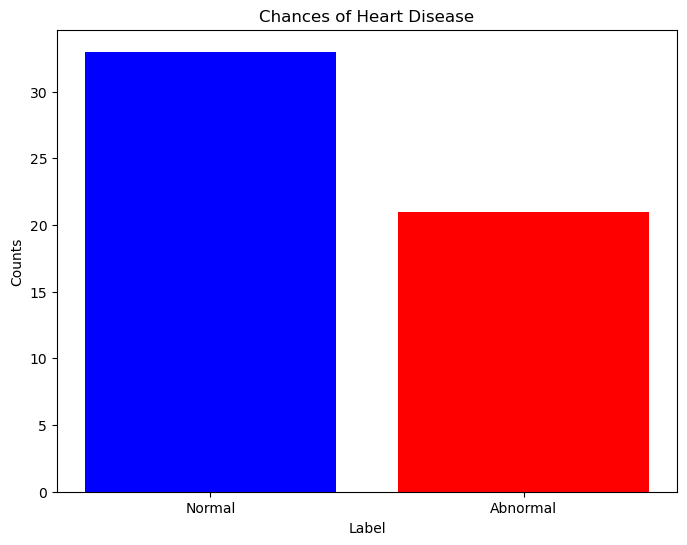

In [25]:
# Plotting Chances of Heart Disease
plt.figure(figsize=(8, 6))
normal_counts = np.sum(y_test == 0)
abnormal_counts = np.sum(y_test == 1)
plt.bar(['Normal', 'Abnormal'], [normal_counts, abnormal_counts], color=['blue', 'red'])
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Chances of Heart Disease')
plt.show()